# Markov Chain Monte Carlo Example 1
Author: Audrey Olivier, Dimitris G. Giovanis, Michael D. Shields <br>
Last modified: October 2019 by Audrey Olivier

In this example, the Metropolis-Hastings is employed to generate samples from a Rosenbrock distribution. The method illustrates various aspects of the UQpy MCMC class:
- various ways of defining the target pdf to sample from,
- definition of input parameters required by the algorithm (proposal_type and proposal_scale for MH),
- running several chains in parallel,
- call diagnostics functions.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the MCMC class from UQpy.

In [1]:
from UQpy.SampleMethods import MCMC, MCMC_v2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
## Explore various ways of defining the target pdf

Define the Rosenbrock probability density function up to a scale factor. Here the pdf is defined directly in the python script <br>
- define the Rosenbrock probability density function up to a scale factor, this function only takes as input parameter the point x where to compute the pdf, <br>
- define a pdf function that also takes as argument a set of parameters params,
- define a function that computes the log pdf up to a constant.
Alternatively, the pdf can be defined in an external file that defines a distribution and its pdf or log_pdf methods (Rosenbrock.py)

In [3]:
def Rosenbrock_no_params(x):
     return np.exp(-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)
    
def Rosenbrock(x, params):
     return np.exp(-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/params[0])
    
def log_Rosenbrock(x):
     return (-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)

(500, 2)


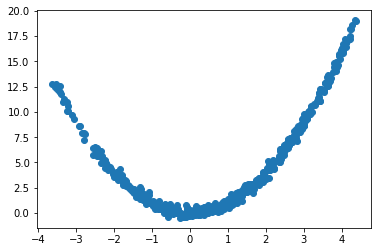

In [4]:
x = MCMC_v2(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
            proposal_type='normal', proposal_scale=[1.,1.], 
            pdf_target=Rosenbrock_no_params, pdf_target_params=None)
print(x.samples.shape)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

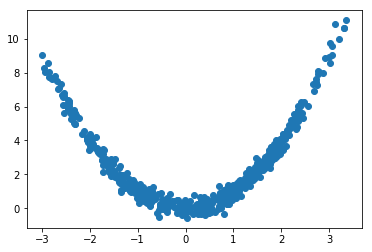

In [5]:
x = MCMC_v2(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
            proposal_type='normal', proposal_scale=[1.,1.],
            pdf_target=Rosenbrock, pdf_target_params = [20])
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

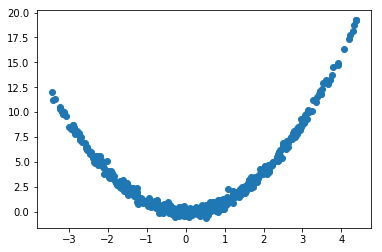

In [6]:
x = MCMC_v2(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
            proposal_type='normal', proposal_scale=[1.,1.],
            log_pdf_target=log_Rosenbrock, pdf_target_params = None)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

In the following, the Rosenbrock.py file is used. It must have a pdf method (if input pdf_target is used) or a log pdf method (if input log_pdf_target is used).

In [7]:
# This call works
x = MCMC_v2(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
            proposal_type='normal', proposal_scale=[1.,1.],
            pdf_target='Rosenbrock', pdf_target_params = [20])

In [8]:
# This one does not, because the file does not possess a log_pdf method: catch the error
try:
    x = MCMC_v2(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
                proposal_type='normal', proposal_scale=[1.,1.],
                log_pdf_target='Rosenbrock', pdf_target_params = [20])
except AttributeError as e:
    print('The code cannot run because Rosenbrock.py does not possess a log_pdf method !!!!, '
          'the following error will be raised')
    print(e)

The code cannot run because Rosenbrock.py does not possess a log_pdf method !!!!, the following error will be raised
log_pdf_target should point to a Distribution with an existing log_pdf method.


## The algorithm-specific parameters for MH are proposal_scale and proposal_type

The default values (if not provided) are 'normal' for proposal_type and 1. in all dimensions for proposal_scale.

proposal_type set as gamma raises the following error:
Only uniform and normal proposal distributions are currently supported.


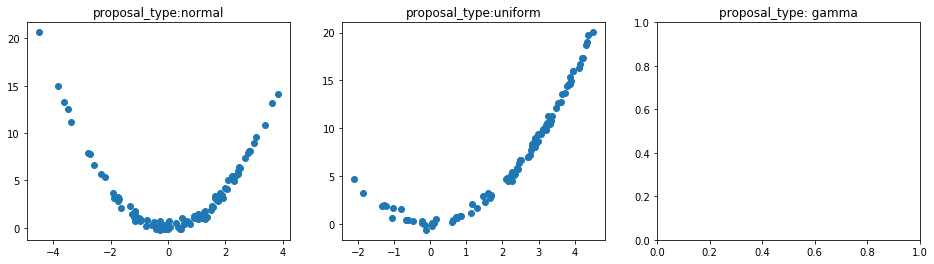

In [9]:
proposal_types = ['normal', 'uniform', 'gamma']
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for i, proposal_type in enumerate(proposal_types):
    try:
        x = MCMC_v2(dimension=2, algorithm='MH', nburn=100, jump=500, nsamples=100, seed=None, 
                    proposal_type=proposal_type, proposal_scale=[1.,1.], log_pdf_target=log_Rosenbrock)
        ax[i].plot(x.samples[:,0], x.samples[:,1], 'o')
        ax[i].set_title('proposal_type:' + proposal_type)
    except NotImplementedError as e:
        print('proposal_type set as gamma raises the following error:')
        print(e)
        ax[i].set_title('proposal_type: ' + proposal_type)
plt.show()

Not providing the input proposal_type works - the default value 'normal' is used

normal


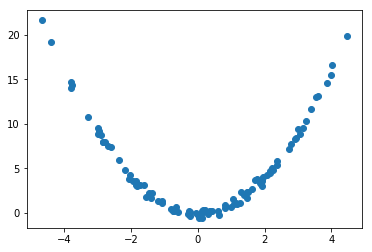

In [10]:
x = MCMC_v2(dimension=2, algorithm='MH', nburn=100, jump=500, nsamples=100, seed=None, 
            log_pdf_target=log_Rosenbrock, proposal_scale=[1.,1.], )
print(x.algorithm_inputs['proposal_type'])
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

wrong proposal_scale raises the following error:
Wrong dimension in scale parameter.


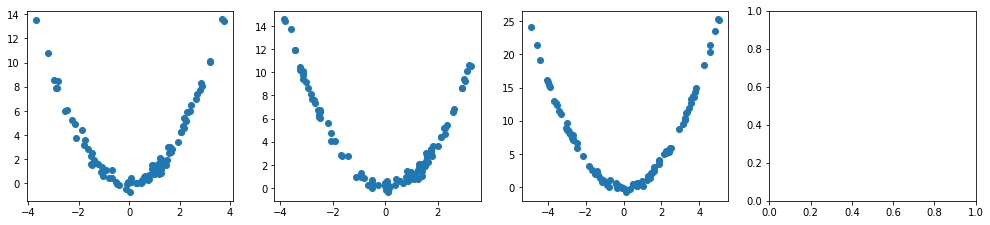

In [11]:
proposal_scales = [1., 0.1, np.array([1., 1.]), np.array([1., 1., 1.])]
fig, ax = plt.subplots(ncols=4, figsize=(17, 3.5))
for i, proposal_scale in enumerate(proposal_scales):
    try:
        x = MCMC_v2(dimension=2, algorithm='MH', nburn=100, jump=500, nsamples=100, seed=None, 
                    proposal_type='normal', proposal_scale=proposal_scale,
                    log_pdf_target=log_Rosenbrock)
        ax[i].plot(x.samples[:,0], x.samples[:,1], 'o')
    except ValueError as e:
        print('wrong proposal_scale raises the following error:')
        print(e)
plt.show()

## Run several chains in parallel

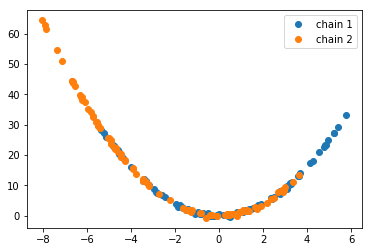

In [12]:
x = MCMC_v2(dimension=2, proposal_type='normal', proposal_scale=[1.,1.],
            log_pdf_target=log_Rosenbrock, pdf_target_params=None, algorithm='MH', jump=1000, 
            nsamples=100, nburn=500, seed=np.array([[0., 0.], [1., 1.]]), concat_chains_=False)
plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', label='chain 1')
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', label='chain 2')
plt.legend()
plt.show()

## Initialize without nsamples... then call run

In [13]:
t = time.time()
x = MCMC_v2(dimension=2, proposal_type='normal', proposal_scale=[1.,1.],
            log_pdf_target=log_Rosenbrock, pdf_target_params=None, algorithm='MH', jump=1000, 
            nburn=500, seed=np.array([[0., 0.], [1., 1.]]), verbose=True, concat_chains_=False)
print('Elapsed time for initialization: {} s'.format(time.time()-t))

Initialization of mcmc algorithm MH completed.
Elapsed time for initialization: 0.0002532005310058594 s


Running MCMC...
MCMC run successfully !
Elapsed time for running MCMC: 4.303872108459473 s
nburn, jump at first run: 500, 1000
total nb of samples: 100


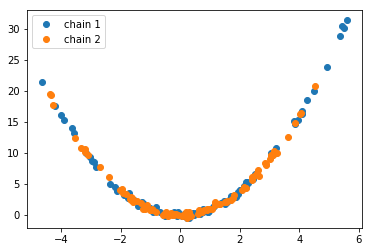

In [14]:
t = time.time()
x.run(nsamples=100)
print('Elapsed time for running MCMC: {} s'.format(time.time()-t))
print('nburn, jump at first run: {}, {}'.format(x.nburn, x.jump))
print('total nb of samples: {}'.format(x.samples.shape[0]))

plt.plot(x.samples[:, 0, 0],x.samples[:, 0, 1],'o', label='chain 1')
plt.plot(x.samples[:, 1, 0],x.samples[:, 1, 1],'o', label='chain 2')
plt.legend()
plt.show()

Running MCMC...
MCMC run successfully !
Elapsed time for running MCMC: 4.1950390338897705 s
nburn, jump at second run: 0, 1000
total nb of samples: 200


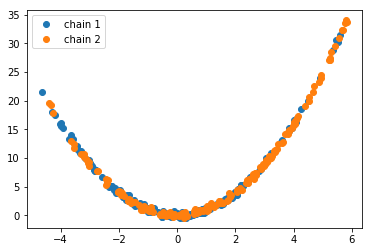

In [15]:
t = time.time()
x.run(nsamples=100)
print('Elapsed time for running MCMC: {} s'.format(time.time()-t))
print('nburn, jump at second run: {}, {}'.format(x.nburn, x.jump))
print('total nb of samples: {}'.format(x.samples.shape[0]))

plt.plot(x.samples[:, 0, 0],x.samples[:, 0, 1],'o', label='chain 1')
plt.plot(x.samples[:, 1, 0],x.samples[:, 1, 1],'o', label='chain 2')
plt.legend()
plt.show()